# Data Gathering

We will start by getting the data from the 'fashion_dataset' directory.

In [ ]:
!wget https://github.com/mohamed-12-4/DSAI--COSC-202-/raw/refs/heads/master/fashion_dataset.zip
!unzip fashion_dataset

Streaming output truncated to the last 5000 lines.
  inflating: fashion_dataset/9/18732.png  
  inflating: fashion_dataset/9/18739.png  
  inflating: fashion_dataset/9/18744.png  
  inflating: fashion_dataset/9/18746.png  
  inflating: fashion_dataset/9/18756.png  
  inflating: fashion_dataset/9/18770.png  
  inflating: fashion_dataset/9/18795.png  
  inflating: fashion_dataset/9/18806.png  
  inflating: fashion_dataset/9/18819.png  
  inflating: fashion_dataset/9/18836.png  
  inflating: fashion_dataset/9/18843.png  
  inflating: fashion_dataset/9/18857.png  
  inflating: fashion_dataset/9/1889.png  
  inflating: fashion_dataset/9/18892.png  
  inflating: fashion_dataset/9/18899.png  
  inflating: fashion_dataset/9/18902.png  
  inflating: fashion_dataset/9/18931.png  
  inflating: fashion_dataset/9/18941.png  
  inflating: fashion_dataset/9/18954.png  
  inflating: fashion_dataset/9/18955.png  
  inflating: fashion_dataset/9/18969.png  
  inflating: fashion_dataset/9/18973.png  
  in

This is a supervised machine learning model that takes in labeled data and trains in identifying cloth items based on corresponding groups. To achieve this, we import various libraries for file access and appending, data manipulation, and machine learning frameworking. Additional numerical and graphing libraries are included.



In [ ]:
import os
import glob
import pandas as pd
import cv2
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

We start by defining a function that takes the path of folder and store the image path and label into a pandas dataframe.
The dataframe's dictionary is updated by going in a loop, using glob.glob, image_path stores the path name and the subfolder, and files within, so that it can append the images and labels arrays defined above.
.split is a method of going up to the second-to-last element, which is the folder containing label names.

In [ ]:
def load_data(path: str) -> pd.DataFrame:
    """
    Load the data from the path and return a pandas dataframe with the images path and labels.
    param path: str: path to the images directory
    """
    images = []
    labels = []
    for image_path in glob.glob(path + '/*/*.png'):
        images.append(image_path)
        labels.append(image_path.split('/')[-2])

    images_df = pd.DataFrame({'images_path': images, 'labels': labels})
    return images_df



In [ ]:
images_df = load_data('./fashion_dataset')

We give load_data the path parameter and it stores the path data as a string, inside images_df, the images dataframe. (path: str)

We then see what the function collected by writing images_df.

# Data Exploration and Visualization

In [ ]:
images_df

,images_path,labels
0,./fashion_dataset/5/26997.png,5
1,./fashion_dataset/5/34319.png,5
2,./fashion_dataset/5/53979.png,5
3,./fashion_dataset/5/23780.png,5
4,./fashion_dataset/5/1476.png,5
...,...,...
59995,./fashion_dataset/1/55918.png,1
59996,./fashion_dataset/1/44061.png,1
59997,./fashion_dataset/1/32308.png,1
59998,./fashion_dataset/1/18273.png,1


value_counts is a pandas function that takes the labels within images_df, and counts the occurence of them. .astype(int) displays them to integers, which is needed by our model.

In [ ]:
images_df.labels = images_df.labels.astype(int)
images_df.labels.value_counts()

,count
labels,
5,6000
8,6000
9,6000
3,6000
4,6000
0,6000
2,6000
6,6000
7,6000


As we can see we have exactly 6,000 images per class which implies that the dataset is balanced

In [ ]:
images_df

,images_path,labels
0,./fashion_dataset/5/26997.png,5
1,./fashion_dataset/5/34319.png,5
2,./fashion_dataset/5/53979.png,5
3,./fashion_dataset/5/23780.png,5
4,./fashion_dataset/5/1476.png,5
...,...,...
59995,./fashion_dataset/1/55918.png,1
59996,./fashion_dataset/1/44061.png,1
59997,./fashion_dataset/1/32308.png,1
59998,./fashion_dataset/1/18273.png,1


By inspection, we can convert each label to a name class for an easier interpretation of that data.

In [ ]:
labels_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

def class_to_name(label) -> str:
    """
    Convert the label to the name of the class
    param label: int: label of the class
    """

    return labels_map[label]

We also created a funtion that views an image given its path.
plt.imshow shows the image from that path.

Pullover


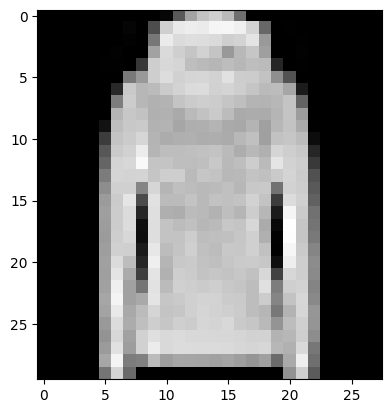

In [ ]:
def view_image(path: str):
    """
    View the image from the path
    param path: str: path to the image
    """
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = cv2.imread(path)
    plt.imshow(img)

index = random.randint(0, len(images_df))
image_path = images_df.images_path[index]
label = images_df.labels[index]
print(class_to_name(label))
view_image(image_path)


We plot the data we gather into a pie chart. There is 10% of every label.

Using class_to_name defined earlier, we apply the label names to the images_df column, based on the labels column.

<Axes: ylabel='count'>

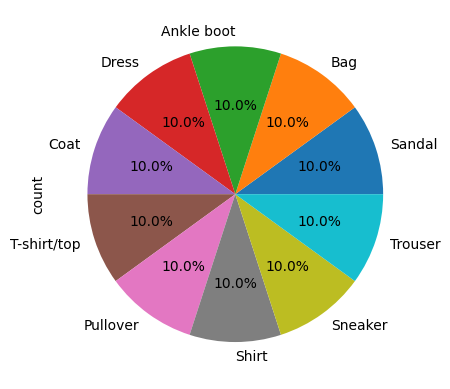

In [ ]:
# plot a pie plot of the classes
images_df['class_name'] = images_df['labels'].apply(class_to_name)

images_df.class_name.value_counts().plot(kind='pie', autopct='%1.1f%%', )

# Data Preprocessing

We start by utlising tf ImageDataGenerator, then we apply flow_from_dataframe function, this will go to each file path in the images dataframe and read it, then it will save it in a dataset, we also have the option to choose the batch size.

In [ ]:
def create_dataset(df: pd.DataFrame, batch_size: int):
    """
    Create the dataset from the dataframe
    param df: pd.DataFrame: dataframe with the images path and labels
    param batch_size: int: batch size of the dataset
    """
    imagegen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)
    dataset = imagegen.flow_from_dataframe(
        df,
        x_col='images_path',
        y_col='labels',
        target_size=(28, 28),
        class_mode='raw',
        batch_size=batch_size,
    )
    return dataset



In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(images_df, test_size=0.2, random_state=42)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)

Then we start by applying the create_dataset function to the train, test, validation splits of the dataframe

In [ ]:
dataset = create_dataset(images_df, 64)
train_dataset = create_dataset(train_df, 64)
test_dataset = create_dataset(test_df, 64)
val_dataset = create_dataset(val_df, 64)

Found 60000 validated image filenames.
Found 48000 validated image filenames.
Found 6000 validated image filenames.
Found 6000 validated image filenames.


In [ ]:
len(dataset) # 938 batches each batch contains 64 images

938

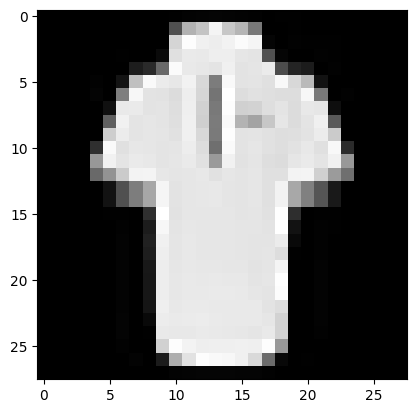

In [ ]:
plt.imshow(dataset[0][0][0])

# Simple NN (Only dense layers)

We start by defining a simple model that only contains Desne layers

In [ ]:
Dense_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
Dense_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 2352)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         301,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,090 (1.18 MB)

 Trainable params: 310,090 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

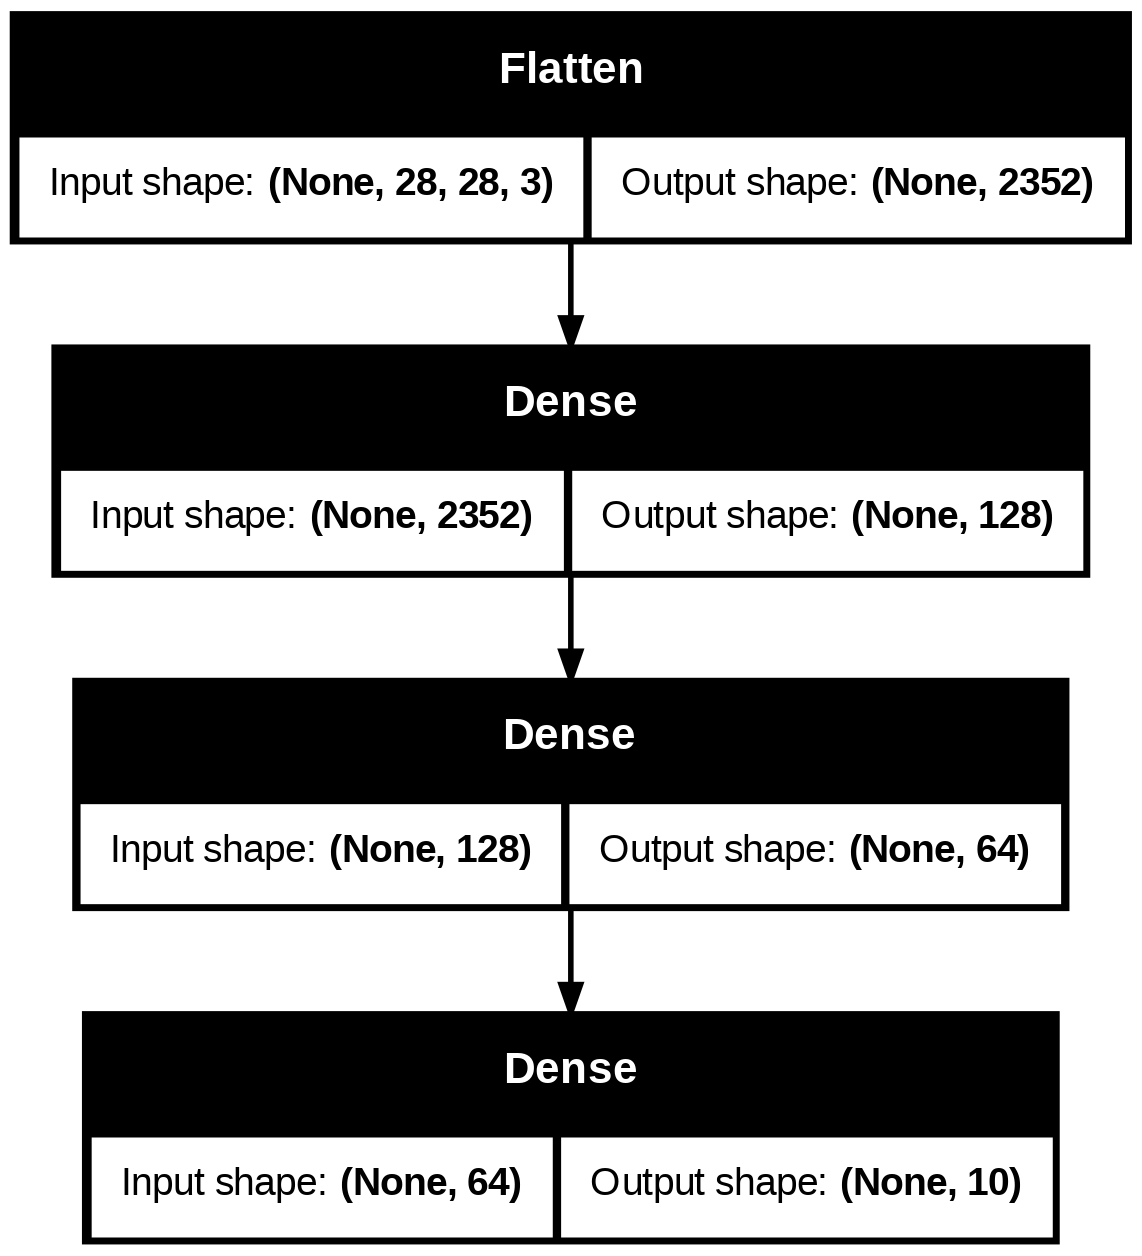

In [ ]:
tf.keras.utils.plot_model(Dense_model, show_shapes=True)

In [ ]:
# adding a callback to prevent the model from overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
Dense_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = Dense_model.fit(train_dataset, epochs=100, callbacks=[callback], validation_data=val_dataset)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.7602 - loss: 0.6916 - val_accuracy: 0.8510 - val_loss: 0.4319
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.8542 - loss: 0.4024 - val_accuracy: 0.8562 - val_loss: 0.3952
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.8692 - loss: 0.3575 - val_accuracy: 0.8658 - val_loss: 0.3747
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8779 - loss: 0.3340 - val_accuracy: 0.8715 - val_loss: 0.3449
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.8791 - loss: 0.3202 - val_accuracy: 0.8700 - val_loss: 0.3567
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.8851 - loss: 0.3037 - val_accuracy: 0.8738 - val_loss: 0.3505
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.8902 - loss: 0.2937 - val_accuracy: 0.8788 - val_loss: 0.3398
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8912 - loss: 0

As we can see the mode has a validation accuracy of around 88%

# Convolutional NN

# Convolutional NN w/MaxPooling layers

Now, we try Convolutional Neural Networks on the data set, we start by a simple one of only Conv and MaxPooling Layers

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='leaky_relu', input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='leaky_relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='leaky_relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='leaky_relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,498 (623.04 KB)

 Trainable params: 159,498 (623.04 KB)

 Non-trainable params: 0 (0.00 B)

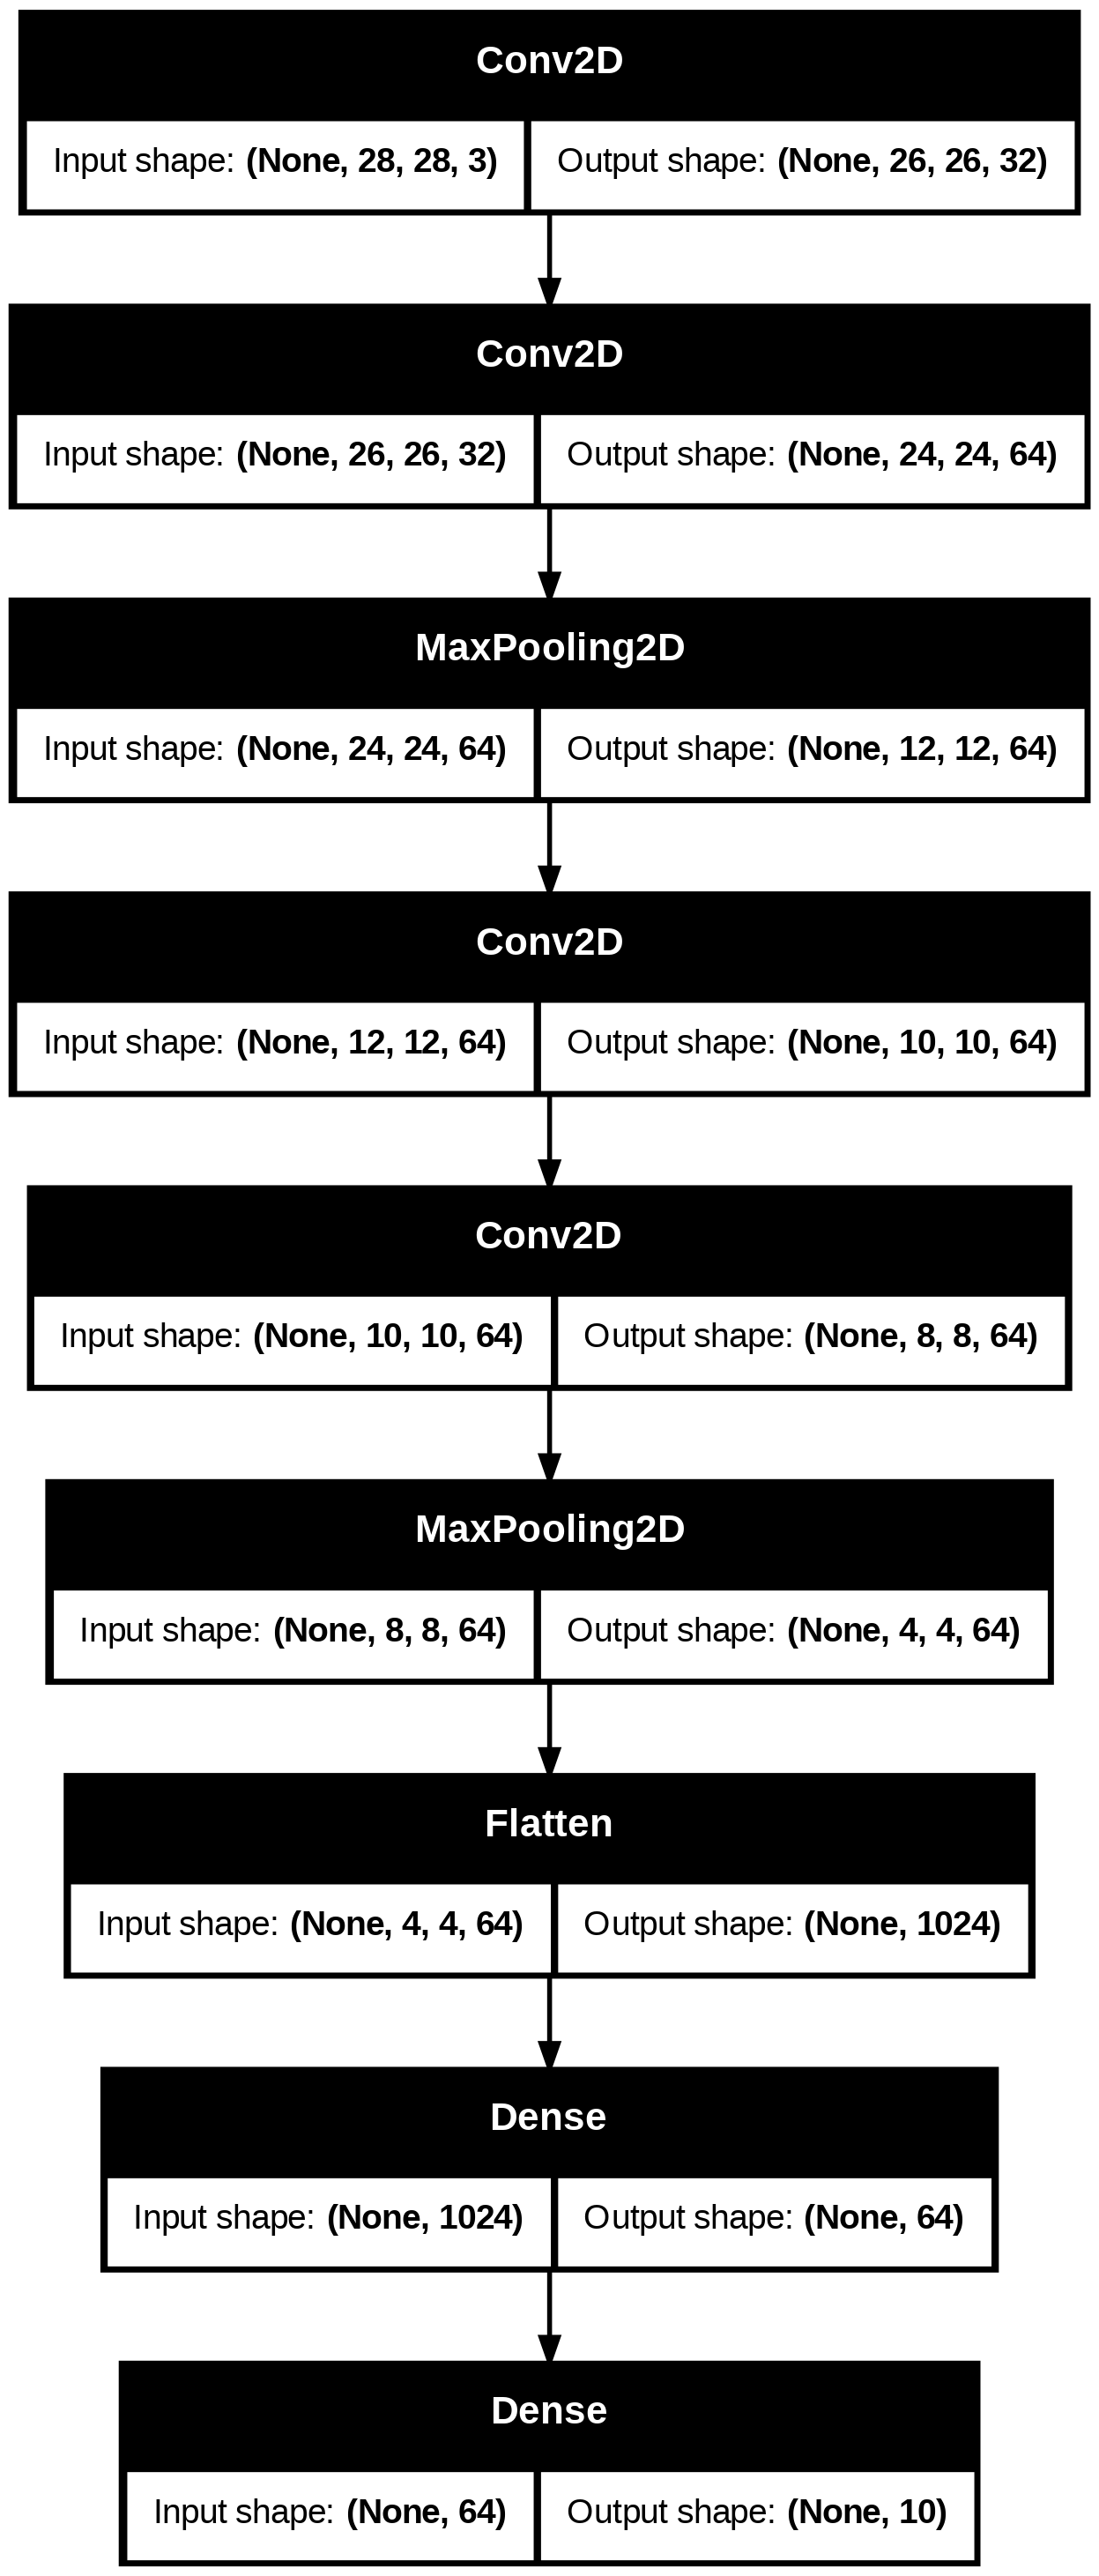

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, epochs=100, callbacks=[callback], validation_data=val_dataset)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


750/750 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.7476 - loss: 0.6945 - val_accuracy: 0.8727 - val_loss: 0.3612
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 36s 25ms/step - accuracy: 0.8865 - loss: 0.3103 - val_accuracy: 0.8967 - val_loss: 0.2875
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9057 - loss: 0.2585 - val_accuracy: 0.9005 - val_loss: 0.2771
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9186 - loss: 0.2271 - val_accuracy: 0.9088 - val_loss: 0.2610
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.9253 - loss: 0.1995 - val_accuracy: 0.8947 - val_loss: 0.2823
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9333 - loss: 0.1808 - val_accuracy: 0.9020 - val_loss: 0.2874
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9399 - loss: 0.1653 - val_accuracy: 0.9125 - val_loss: 0.2562
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9434 - loss: 0.1496 - val_

We noticed that this model perform slightly better on the data acheaving around 90% in validation accuracy

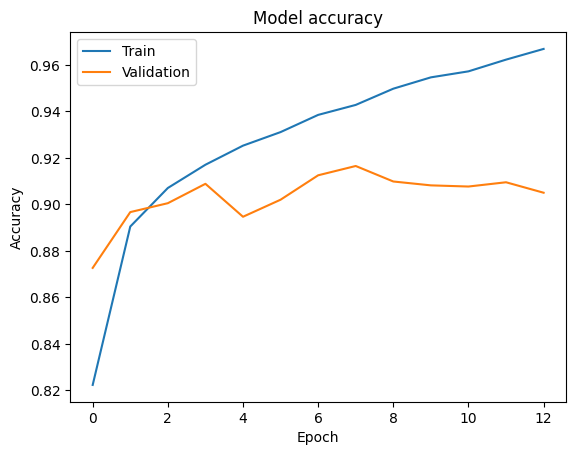

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Convolutional NN + Regulization / Normalization layers

Now we Try a better one that have an extra Regualization (Dropout layers) and Normalization Layers. These layers will prevent the model from overfitting.

In [ ]:
CNNR_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='leaky_relu', input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='leaky_relu'),
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='leaky_relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='leaky_relu'),
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
CNNR_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)                   │ (None, 26, 26, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 24, 24, 32)          │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 10, 10, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_1 (Normalization)      │ (None, 8, 8, 64)            │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,012 (515.68 KB)

 Trainable params: 131,818 (514.91 KB)

 Non-trainable params: 194 (784.00 B)

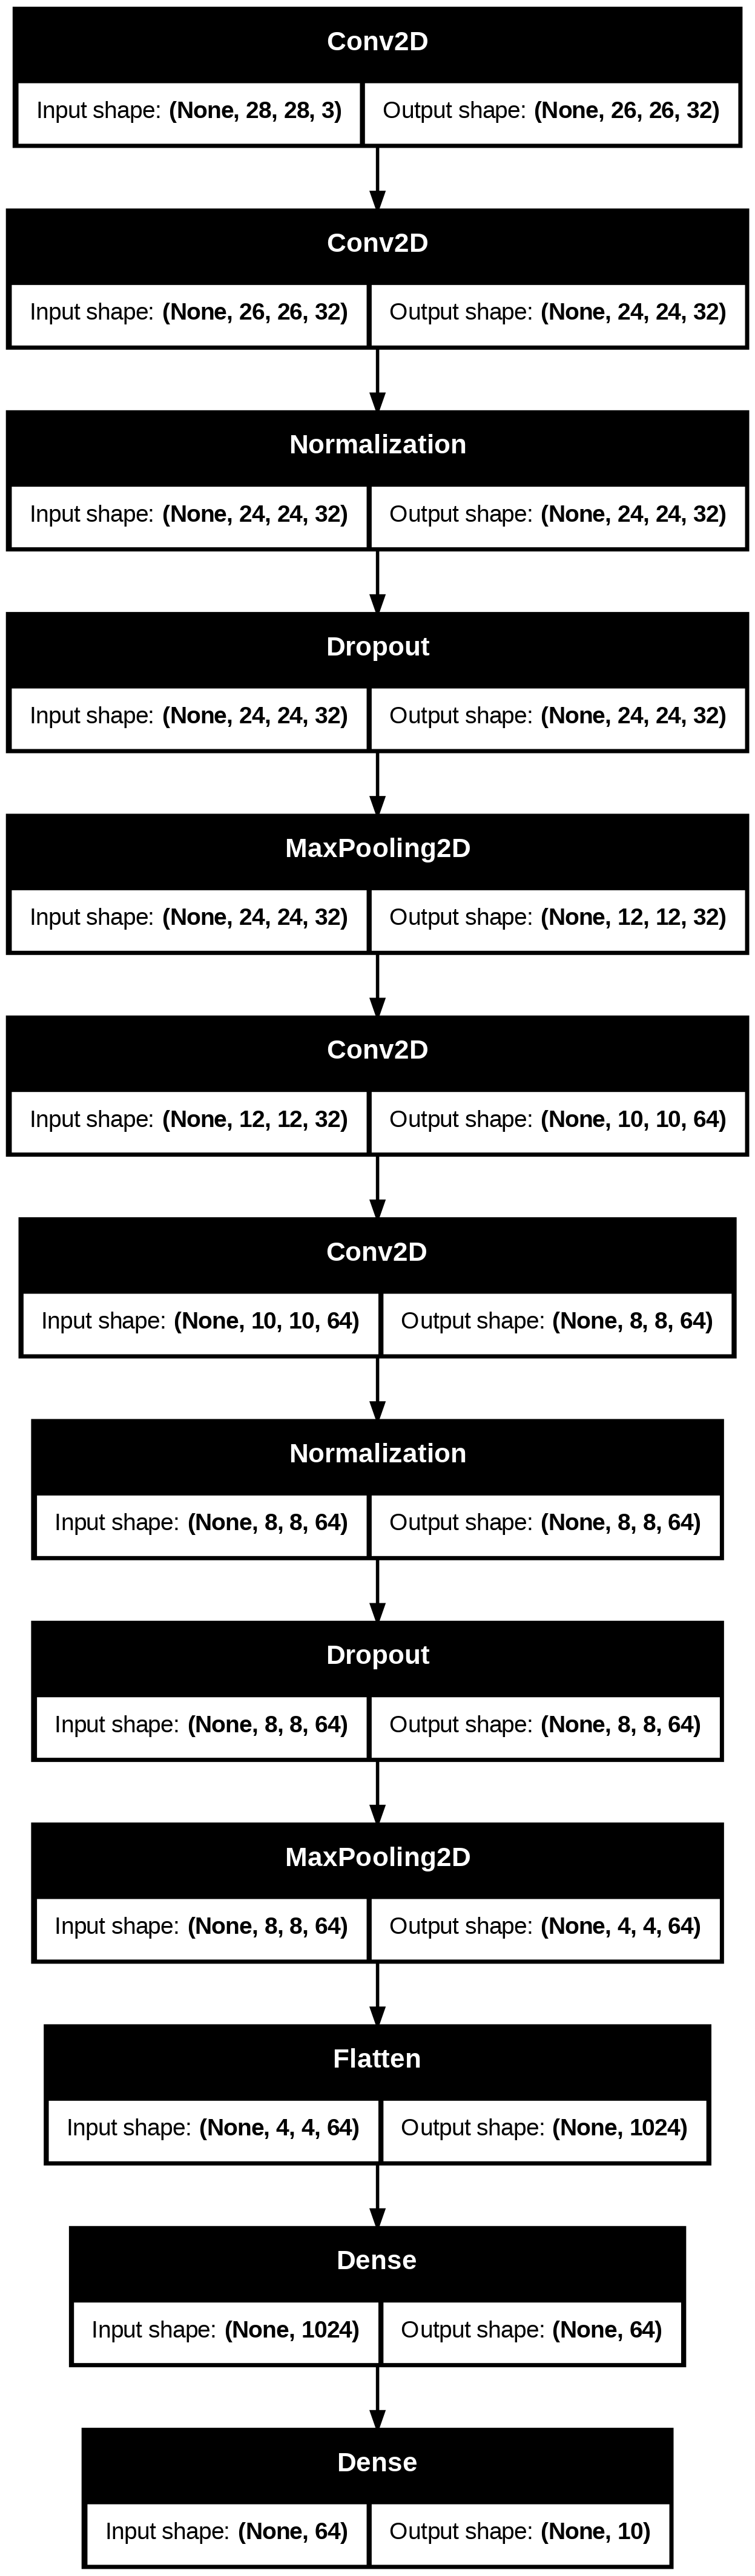

In [ ]:
tf.keras.utils.plot_model(CNNR_model, show_shapes=True)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
CNNR_model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = CNNR_model.fit(train_dataset, epochs=100, callbacks=[callback], validation_data=val_dataset)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.7501 - loss: 0.6978 - val_accuracy: 0.8693 - val_loss: 0.3765
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.8802 - loss: 0.3223 - val_accuracy: 0.8880 - val_loss: 0.3129
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8980 - loss: 0.2743 - val_accuracy: 0.9002 - val_loss: 0.2799
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9084 - loss: 0.2476 - val_accuracy: 0.9002 - val_loss: 0.2788
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9145 - loss: 0.2320 - val_accuracy: 0.9097 - val_loss: 0.2520
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9229 - loss: 0.2164 - val_accuracy: 0.9075 - val_loss: 0.2609
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.9238 - loss: 0.2027 - val_accuracy: 0.9122 - val_loss: 0.2487
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.9296 - loss: 0

We can see that this model is better than the previous two with 91.5% calidation accuracy

In [ ]:
CNNR_model.evaluate(test_dataset)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9234 - loss: 0.2260


[0.23158198595046997, 0.9211666584014893]

We will choose the last model as our best one

Lastly we save the model to be tested on real-life data on another notebook file

In [ ]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(CNNR_model, f)